In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

In [2]:
import pandas as pd
import numpy as np
import astropy.units as u
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

## Read data as pd DataFrame

In [3]:
with open('../Astr511HW1data.dat', 'r') as ff:
    line1 = ff.readline()
    cols = line1.strip('#').split()

df = pd.read_csv('../Astr511HW1data.dat', comment='#', delim_whitespace=True, names=cols)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576801 entries, 0 to 576800
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ra      576801 non-null  float64
 1   dec     576801 non-null  float64
 2   run     576801 non-null  int64  
 3   Ar      576801 non-null  float64
 4   u       576801 non-null  float64
 5   g       576801 non-null  float64
 6   r       576801 non-null  float64
 7   i       576801 non-null  float64
 8   z       576801 non-null  float64
 9   uErr    576801 non-null  float64
 10  gErr    576801 non-null  float64
 11  rErr    576801 non-null  float64
 12  iErr    576801 non-null  float64
 13  zErr    576801 non-null  float64
 14  pmL     576801 non-null  float64
 15  pmB     576801 non-null  float64
 16  pmErr   576801 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 74.8 MB


In [5]:
df.head()

,ra,dec,run,Ar,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,pmL,pmB,pmErr
0,181.61220,27.57260,5087,0.05,16.40,15.24,14.80,14.73,14.69,0.02,0.02,0.02,0.02,0.01,5.16,-1.45,2.72
1,181.61303,27.60770,5087,0.05,21.84,19.55,18.40,18.04,17.79,0.18,0.02,0.02,0.02,0.02,5.48,4.73,3.16
2,181.61416,27.35956,5112,0.05,19.76,17.56,16.61,16.23,16.07,0.03,0.01,0.02,0.03,0.03,3.14,7.92,2.79
3,181.61640,27.82464,5112,0.06,21.73,20.63,20.19,19.99,20.04,0.16,0.03,0.03,0.03,0.13,19.13,-1.08,5.08
4,181.62112,28.01623,5087,0.05,21.37,20.38,20.11,20.05,19.87,0.11,0.04,0.03,0.03,0.09,-3.65,-8.00,4.91


## Calculate Metalliticites Fe/H

\begin{equation}
[Fe/H] = A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3
\end{equation}
$x = (u - g) \\
y = (g - r) \\
(A - J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)$

In [6]:
df['x'] = df['u'] - df['g']
df['y'] = df['g'] - df['r']

coeff = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)
A, B, C, D, E, F, G, H, I, J = coeff

metallicity = lambda x, y: A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x**2*y + H*x*y**2 + I*x**3 + J*y**3

df['Fe/H'] = -0.6
df.loc[(df['y'] < 0.6), 'Fe/H'] = metallicity(df.loc[(df['y'] < 0.6), 'x'], df.loc[(df['y'] < 0.6), 'y'])

## Calculate Absolute Mag in r from Fe/H and g - r

#### Fiducial Abs Mag in r $M^0_r$
A7
\begin{equation}
M^0_r (g - i) = -5.06 + 14.32x - 12.97x^2 + 6.127x^3 - 1.267x^4 + 0.0967x^5
\end{equation}

#### Metalicity Correction $\Delta M_r$
A2
\begin{equation}
\Delta M_r([Fe/H]) = 4.50 - 1.11 [Fe/H] - 0.18[Fe/H]^2
\end{equation}

#### Fitted Abs Mag in r $M_r$
A3
\begin{equation}
M_r(g - i, [Fe/H]) = M^0_r (g - i) + \Delta M_r([Fe/H])
\end{equation}




In [7]:
# A2
df['DelMr'] = 4.50 - 1.11 * df['Fe/H'] - 0.18 * df['Fe/H'] ** 2

# A7
fiducial_M_r = lambda x: -5.06 + 14.32*x - 12.97*x**2 + 6.127*x**3 - 1.267*x**4 + 0.0967*x**5
df['FidcMr'] = fiducial_M_r(df['g'] - df['i'])

# A3
df['Mr'] = df['FidcMr'] + df['DelMr']

## Calculate Z, distance above galactic plane

For distance from galactic plane Z

We assume 

$Z = D$

and 

$r - M_r = 5 * log(D/(10pc))$

Solving for D:

$D = 10^{0.2 * (r - M_r) + 1} pc$


In [8]:
df['Z'] = 10 ** ((df['r'] - df['Mr']) / 5) * 10  # pc
df['Z(kpc)'] = df['Z'] / 1000

## Problem 1
For stars with $0.2 < g - r < 0.4$, plot $ln(\rho)$ vs. $Z$ where $\rho$ is the stellar number density in a given bin, Approximate 

$\rho(Z) = N(Z) / V(Z)$

where N is the number of stars in a given bin, V is the bin volume.

In [9]:
gr24 = df.loc[((df['g'] - df['r']) < 0.4) & ((df['g'] - df['r']) > 0.2)]

In [10]:
sa = (314 * u.deg **2).to(u.sr).value

In [11]:
# Helper functions

def get_vol_elements(n, bin_size, bin_start, solid_angle, method='avg', disp=False):
    def puck_vol(distance, sa, thickness):
        return sa * distance ** 2 * thickness
    def cone_vol(distance, sa):
        return 1/3 * distance ** 3 * sa 
    
    lower_bound = np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    upper_bound = np.arange(bin_start + bin_size, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    lower_bound = np.round(lower_bound, 6)
    upper_bound = np.round(upper_bound, 6)
    
    if method == 'avg':
        dVs =  0.5 * (puck_vol(lower_bound, solid_angle, bin_size) + 
                      puck_vol(upper_bound, solid_angle, bin_size))
        
    elif method == 'lower':
        dVs = puck_vol(lower_bound, solid_angle, bin_size)
            
    elif method == 'upper':
        dVs = puck_vol(upper_bound, solid_angle, bin_size)
        
    elif method == 'exact':
        dVs = cone_vol(upper_bound, solid_angle) - cone_vol(lower_bound, solid_angle)
    
    if disp:
        for ii in range(n):
            print(f'from {lower_bound[ii]} to {upper_bound[ii]}:\t {dVs[ii]}')
    
    return dVs
    
def get_star_counts(distance_arr, n, bin_size, bin_start, disp_table=False):
    bounds =  np.arange(bin_start, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)
    counts, bins = np.histogram(distance_arr, bins=bounds)
    if disp_table:
        for ii in range(n):
            print(f'from {bounds[ii]} to {bounds[ii+1]}:\t {counts[ii]}')
    return counts
       
def plot_dens_hist(n, bin_size, bin_start, distance_arr, label, func=np.log, return_vals=False):
    sa = (314 * u.deg **2).to(u.sr).value
    V = get_vol_elements(n, bin_size, bin_start, sa)
    N = get_star_counts(distance_arr, n, bin_size, bin_start)
    bounds =  np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)
    plt.step(bounds, func(N/V), label=label)
    if return_vals == True:
        return bounds, N, N/V

In [12]:
(get_vol_elements(40, 0.4, 0.8, sa, 'exact') / get_vol_elements(40, 0.4, 0.8, sa, 'avg'))

array([0.97435897, 0.98666667, 0.99186992, 0.99453552, 0.99607843,
       0.99705015, 0.99770115, 0.99815838, 0.9984917 , 0.99874214,
       0.99893504, 0.99908676, 0.99920823, 0.999307  , 0.99938838,
       0.99945623, 0.99951338, 0.99956198, 0.99960365, 0.99963964,
       0.99967094, 0.99969834, 0.99972245, 0.99974379, 0.99976275,
       0.99977969, 0.99979487, 0.99980854, 0.99982088, 0.99983207,
       0.99984225, 0.99985152, 0.99986   , 0.99986778, 0.99987492,
       0.9998815 , 0.99988758, 0.9998932 , 0.9998984 , 0.99990324])

In [13]:
get_star_counts(gr24['Z(kpc)'], 20, .4, .8, disp_table=True)

from 0.8 to 1.2:	 2102
from 1.2 to 1.6:	 3235
from 1.6 to 2.0:	 3409
from 2.0 to 2.4:	 3307
from 2.4 to 2.8:	 3194
from 2.8 to 3.2:	 2879
from 3.2 to 3.6:	 2792
from 3.6 to 4.0:	 2640
from 4.0 to 4.4:	 2657
from 4.4 to 4.8:	 2676
from 4.8 to 5.2:	 2590
from 5.2 to 5.6:	 2687
from 5.6 to 6.0:	 2713
from 6.0 to 6.4:	 2799
from 6.4 to 6.8:	 2834
from 6.8 to 7.2:	 2804
from 7.2 to 7.6:	 2942
from 7.6 to 8.0:	 2938
from 8.0 to 8.4:	 3050
from 8.4 to 8.8:	 3004


array([2102, 3235, 3409, 3307, 3194, 2879, 2792, 2640, 2657, 2676, 2590,
       2687, 2713, 2799, 2834, 2804, 2942, 2938, 3050, 3004], dtype=int64)

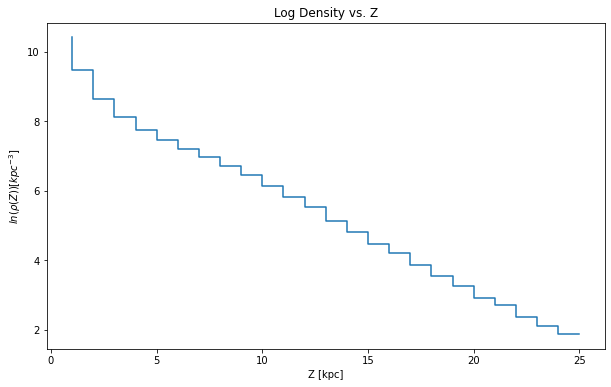

In [14]:
plt.title('Log Density vs. Z')
plot_dens_hist(n=25, bin_size=1, bin_start=1, label='', distance_arr=gr24['Z(kpc)'])
plt.xlabel('Z [kpc]')
plt.ylabel(r'$ln(\rho(Z)) [kpc^{-3}]$')
plt.show()

#### How far out do we trust our estimates for?

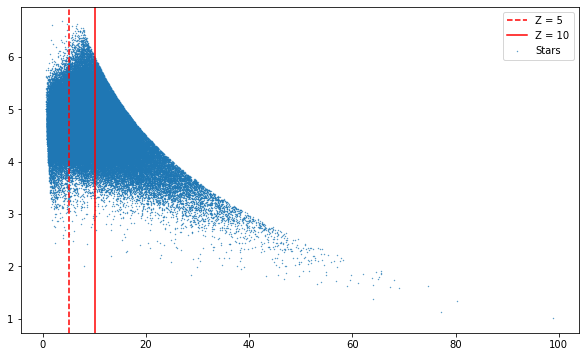

In [15]:
SDSS_maglim=22.5

plt.scatter(gr24['Z(kpc)'], gr24['Mr'], label='Stars', marker='.', s=0.5)
plt.axvline(5, label='Z = 5', color='r', linestyle='--')
plt.axvline(10, label='Z = 10', color='r')
# plt.plot(np.linspace(1, 100, 1001), -5 * np.log(np.linspace(1, 100, 1001)/10) - SDSS_maglim)
plt.legend()

Based on the plot above, we become flux limited at some distance between $Z = 5$ and $Z = 10$. Thus I would only trust our densities for $Z \leq 7$ or so.

## Problem 2

In [16]:
g_r_bounds = [(round(x, 2), round(x+.2, 2)) for x in np.arange(0.2, 1, 0.2)]

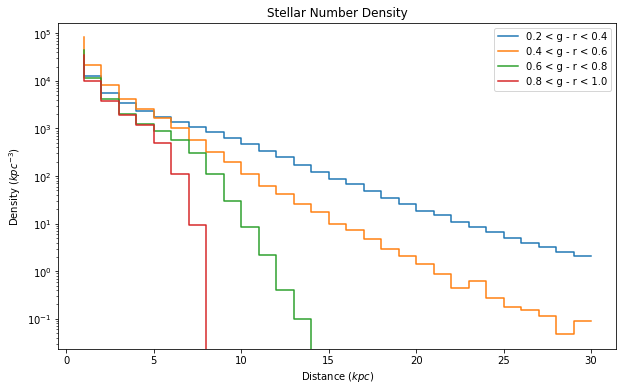

In [17]:
plt.figure()
plt.title('Stellar Number Density')
for lower, upper in g_r_bounds:
    dists = df.loc[((df['g'] - df['r']) < upper) & ((df['g'] - df['r']) > lower), 'Z(kpc)']
    label = f"{lower} < g - r < {upper}"
    plot_dens_hist(n=30, bin_size=1, bin_start=1, distance_arr=dists, label=label, func=lambda x: x)
plt.yscale('log')
plt.xlabel(r'Distance ($kpc$)')
plt.ylabel(r'Density ($kpc^{-3}$)')
plt.legend()
plt.show()

Redder stars (higher g - r values) are generally dimmer. Thus the reddest stars in our sample tend to be the dimmest and we undercount them fairly early kpc, as the main sequence stars in those colors become flux-limited.

Our photometric metalicity relation does not work well for very red stars (see Bond et al. 2010). Thus we use \[Fe/H\] = -0.6 for stars redder than g - r > 0.6. This estimate is more precise for stars between 0.6 < g - r < 0.8 than for stars with 0.8 < g - r < 1.0.

## Problem 3

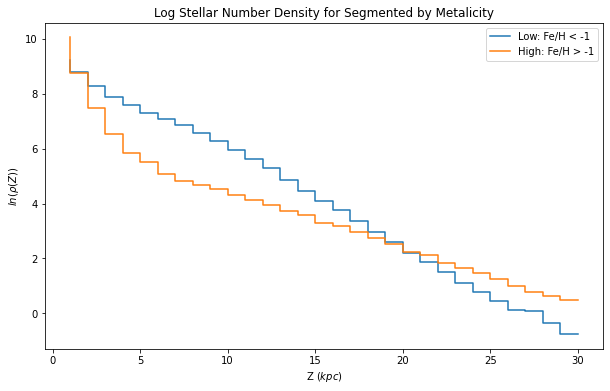

In [18]:
plt.figure()
plt.title('Log Stellar Number Density for Segmented by Metalicity')
low_sample = gr24.loc[gr24['Fe/H'] < -1]
high_sample = gr24.loc[gr24['Fe/H'] > -1]

plot_dens_hist(30, 1, 1, low_sample.loc[:, 'Z(kpc)'], 'Low: Fe/H < -1', func=np.log)
plot_dens_hist(30, 1, 1, high_sample.loc[:, 'Z(kpc)'], 'High: Fe/H > -1', func=np.log)
# plt.yscale('log')
plt.xlabel(r'Z ($kpc$)')
plt.ylabel(r'$ln(\rho(Z))$')
plt.legend()
plt.show()

It appears that past Z~3-4 kpc, we become dominated by low metalicity stars. This may be because these are halo stars, which formed long ago in relatively metal poor star forming conditions.

At around Z ~ 20kpc, our sample becomes dominated by high metallicity stars again. This is due to contamination from faint high metalicity stars being misclassified by our photometric metalicity relation (probably due to large photometric errors). This also causes the absolute magnitude to be artificially large, which in turn leads to a value of D that is larger than reality as well. In fact, from the trends on the plot above, the "high" metallicity population is dominated by misclassified stars past a distance of Z ~ 6 or so.

##### Fitting this plot
I would fit the blue line (low metallicity) with a power law, focusing between 1 < Z < 7, where I am not yet flux limited. This represents the halo distribution of stars

For the orange (high metalliticty) line, I would fit the section between 0 < z < 4 with an exponential. past Z ~ 5, the "high metallicity" curve in our data is dominated by contamination from misestmates of faint stars with large photometric error, and so that portion of the cure follows a power law (since it is really made of halo stars)

In [19]:
# low_sample['g_r'] = low_sample['g'] - low_sample['r']
# high_sample['g_r'] = high_sample['g'] - high_sample['r']

# Explore high vs low metallicity for certain Z

# low_sample.loc[low_sample['Z(kpc)'] > 10, 'Mr'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 10, 'Mr'].hist(alpha=.5, label='high')
# plt.legend()

# low_sample.loc[low_sample['Z(kpc)'] > 20, 'g_r'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 20, 'g_r'].hist(alpha=.5, label='high')


# low_sample.loc[low_sample['Z(kpc)'] > 30, 'Fe/H'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 30, 'Fe/H'].hist(alpha=.5, label='high')
# plt.legend()

## Problem 4

Text(0, 0.5, 'log_{10}(Number of stars)')

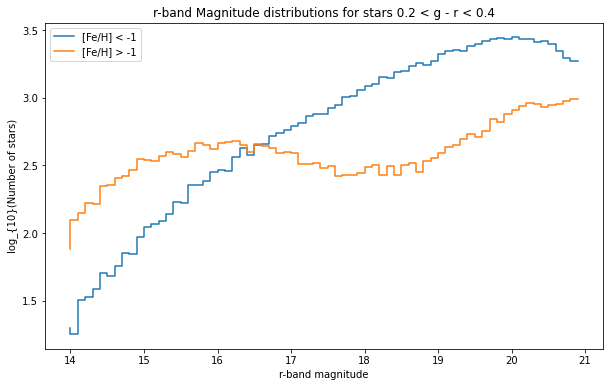

In [20]:
low_counts, low_Mr = np.histogram(low_sample['r'], bins=np.linspace(14,21, 71))
high_counts, high_Mr = np.histogram(high_sample['r'], bins=np.linspace(14, 21, 71))

plt.title('r-band Magnitude distributions for stars 0.2 < g - r < 0.4')
plt.step(low_Mr[:-1], np.log10(low_counts), label='[Fe/H] < -1')
plt.step(high_Mr[:-1], np.log10(high_counts), label='[Fe/H] > -1')
plt.legend()
plt.xlabel('r-band magnitude')
plt.ylabel(r'log_{10}(Number of stars)')

Again we will assume that high metallicity is a proxy for disk stars and low metallicity for halo stars. Furthermorse, since we are looking at a specific color band (0.2 < g - r < 0.4), and in one direction, we will assume that apparent magnitude more or less correlates with distance.

Our sample of higher metalicity stars _appears_ to be bimodal, while lower metalicity stars drop off more consistently with respsect to apparent magnitude. Since the density of halo stars falls off as a power law with respect to distance we expect this to be a straight line. However, due to flux limitations, we are undersampling the fainter stars at fainter apparent magnitude. This results in the curve in the blue line above appearing to flatten out at dimmer magnitudes.

The higher metalicity stars on the other hand displays more interesting behavior. The first bump shows the scale height of the galaxy, and the distance to the edge of the disk, which happens around magnitude 16. The initial rise is due to the increase in volume as we observe further out, followed by an exponential dropoff as we move past the scale height. Note that we could get different scale heights depending on the color of stars (i.e. thin disk vs thick disk). The latter bump is due to contamination for halo stars. When photometric errors are high, such as for the faintest stars, our photometric metallicity function does not account for these uncertainties, and we may misclassify some of these stars as a result. Note how the latter bump appears to parallel the low metallicity stars.

Due to the way we estimate distance, we will grossly overestimate the distance to the "high metallicity" stars between 18 < r < 21. This is because we apply a "metallicity correction" (i.e. eqn A2) to the absolute magnitudes, and so we will overestimate the absolute magnitudes of these stars, as well as the distance to these stars. These stars form the bulk of the "high metallicity" tail in figure in P3, stars whose miscalculated metalicity has pushed our estimates for their distance much further out than they otherwise should be.

##### fitting functions
If I were to fit the functions in the plot above, I would use a power law for the portion of the blue, "low metallicity" curve that is not yet flux limited. I would also exclude the "contamination portion" of the high metallicity curve and fit the disk portion separately. (see response to Problem 3 for more about fitting)

## Problem 5

In order to not be flux limited out to 100kpc, we would need a telescope that could detect stars of absolute magnitude ~6.5 in the r band. This corresponds to apparent magnitude of:

In [21]:
r = 6.5 + 5 * np.log10(100000 / 10)
print(f"r = {r}")

r = 26.5


Steps for estimating stars with 0.2 < g - r < 0.4 at 90-100kpc:

1. Determine a distance at which our sample is dominated by halo stars, but not flux limited (e.g. Z = 5), and find the density at that distance
2. Calculate distance from the galactic center assuming we are 8.0kpc from the center and using the Pythagorian Theorem: $R^ 2 = (8.0 kpc)^2 + Z^2$
3. Assume a distance, density distribution relation with a $\rho \propto \frac{1}{R^3}$ relation. Use this relation to extrapolate to distances between 90 and 100 kpc.

#### Step 1: determine a Z distance at which we are not flux limited, dominated by halo stars, and contamination is low 
and find the density at that distance

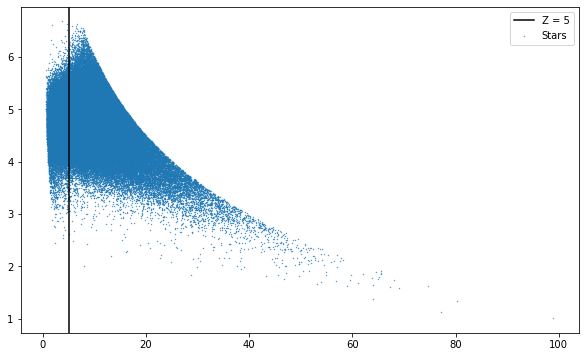

In [22]:
SDSS_maglim=22.5

plt.scatter(gr24['Z(kpc)'], gr24['Mr'], label='Stars', marker='.', s=0.5)
plt.axvline(5, label='Z = 5', color='k')
# plt.axvline(10, label='Z = 10', color='r')
# plt.plot(np.linspace(1, 100, 1001), -5 * np.log(np.linspace(1, 100, 1001)/10) - SDSS_maglim)
plt.legend()

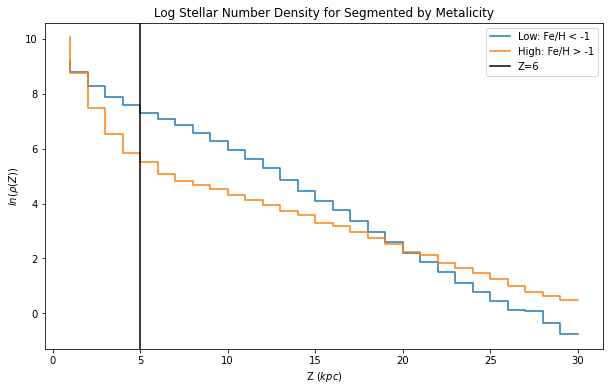

In [23]:
plt.figure()
plt.title('Log Stellar Number Density for Segmented by Metalicity')
low_sample = gr24.loc[gr24['Fe/H'] < -1]
high_sample = gr24.loc[gr24['Fe/H'] > -1]

plot_dens_hist(30, 1, 1, low_sample.loc[:, 'Z(kpc)'], 'Low: Fe/H < -1', func=np.log)
plot_dens_hist(30, 1, 1, high_sample.loc[:, 'Z(kpc)'], 'High: Fe/H > -1', func=np.log)
plt.axvline(5, label='Z=6', color='k')
plt.xlabel(r'Z ($kpc$)')
plt.ylabel(r'$ln(\rho(Z))$')
plt.legend()
plt.show()

and the corresponding apparent magnitude, which is

In [24]:
5.5 + 5 * np.log10(5000/10)  # where 5.5 is the median halo star M_r and Z = 6000 pc

18.994850021680094

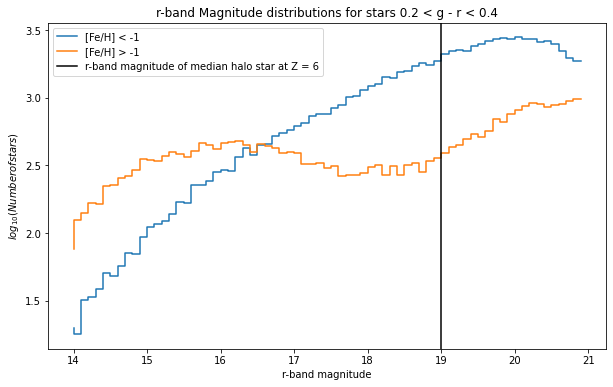

In [25]:
low_counts, low_Mr = np.histogram(low_sample['r'], bins=np.linspace(14,21, 71))
high_counts, high_Mr = np.histogram(high_sample['r'], bins=np.linspace(14, 21, 71))

plt.title('r-band Magnitude distributions for stars 0.2 < g - r < 0.4')
plt.step(low_Mr[:-1], np.log10(low_counts), label='[Fe/H] < -1')
plt.step(high_Mr[:-1], np.log10(high_counts), label='[Fe/H] > -1')
plt.axvline(19, label='r-band magnitude of median halo star at Z = 6', color='k')
plt.legend()
plt.xlabel('r-band magnitude')
plt.ylabel(r'$log_{10}(Number of stars)$')
plt.show()

Z = 5 seems to fit our criteria. The density at Z = 5 is:

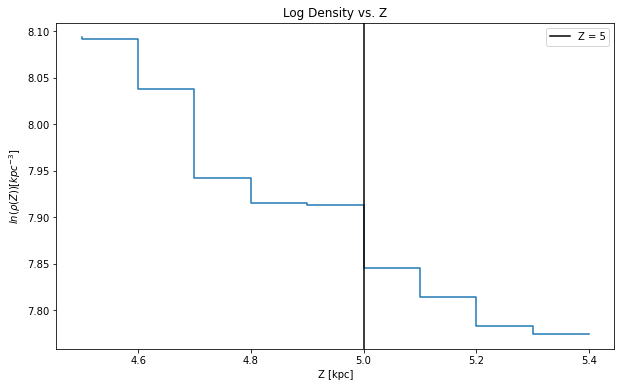

In [26]:
plt.title('Log Density vs. Z')
Zs, nums, dens = plot_dens_hist(n=10, bin_size=.1, bin_start=4.5, label='', distance_arr=gr24['Z(kpc)'], return_vals=True)
plt.xlabel('Z [kpc]')
plt.ylabel(r'$ln(\rho(Z)) [kpc^{-3}]$')
plt.axvline(5, label='Z = 5', color='k')
plt.legend()
plt.show()

In [27]:
print(f"The density around Z = {Zs[5]} kpc is {round(dens[5], 0)} stars / kpc^3")

The density around Z = 5.0 kpc is 2734.0 stars / kpc^3


#### Step 2: calculate distance from galactic center to Z = 5

In [28]:
def R_to_Z(R):
    # pdb.set_trace()
    R = np.array([max(x, 8) for x in R])
    Z2 = np.array([R ** 2 - 8 ** 2])
    return np.sqrt(Z2)[0]

def Z_to_R(Z):
    return np.sqrt(Z ** 2 + 8 ** 2)

print(f"Z = 5 kpc corresponds to R = {round(Z_to_R(5), 2)} kpc")

Z = 5 kpc corresponds to R = 9.43 kpc


#### Step 3 extrapolate to 90 < z < 100 kpc using 1/R^3 relationship

In [29]:
def extrapolate_pt_est(R0, rho0, R):
    return rho0 / ((R / R0) ** 3)

In [30]:
Rs = np.linspace(90, 100, 100)
integrated_total = sum(extrapolate_pt_est(9.43, 2734, Rs) * get_vol_elements(100, .1, 90, (1 * u.deg **2).to(u.sr).value))
print(f"We expect to see around {int(integrated_total)} stars between 90 and 100 kpc")

We expect to see around 73 stars between 90 and 100 kpc


See Appendix A.2 for fitted version with metallicity cut

# Appendix A

## A.1 See below for original work on Problem 5

Steps for estimating stars with 0.2 < g - r < 0.4 at 90-100kpc:

1. Determine distance (upper bound on Z) at which stars in this band become flux limited
2. Determine distance that we begin to be dominated by halo stars (lower bound on Z)
3. Calculate distance from the galactic center assuming we are 8.0kpc from the center and using the Pythagorian Theorem: $R^ 2 = (8.0 kpc)^2 + Z^2$
4. Fit distance, density relation with a $\rho \propto \frac{1}{R^n}$ relation.
5. Use the fit to extrapolate to distances between 90 and 100 kpc.

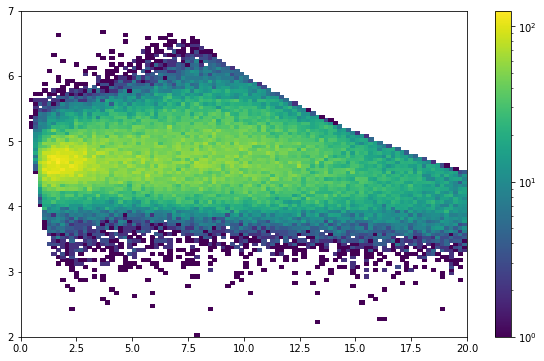

In [31]:
h = plt.hist2d(gr24['Z(kpc)'], gr24['Mr'], label='Stars', bins=100, norm=LogNorm(), range=[[0, 20], [2, 7]])
plt.colorbar(h[3])

It appears flux limiting occurs around Z~7

Additionally, we set Z ~ 4 to be the edge of the disk (See appendix A)

In [32]:
Z_min, Z_max = 4, 7
non_limited = gr24.loc[(gr24['Z(kpc)'] > Z_min) & (gr24['Z(kpc)'] < Z_max)]
non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)

<ipython-input-32-e4e031ef6129>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)


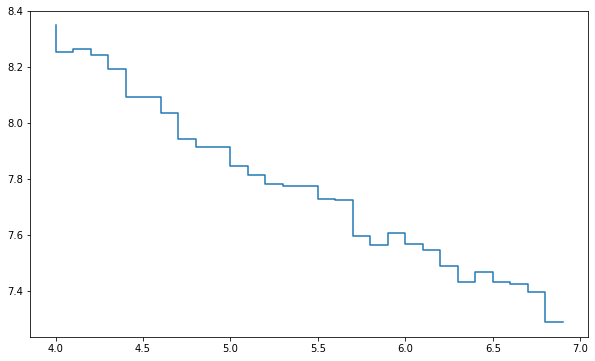

In [33]:
nsteps = 30
step_size = (Z_max - Z_min)/nsteps
dist_Z, num, dens = plot_dens_hist(nsteps, step_size, Z_min, non_limited['Z(kpc)'], label='', return_vals=True)

In [34]:
dist_R = Z_to_R(dist_Z)
dist_R

array([ 8.94427191,  8.98943825,  9.0354856 ,  9.08240056,  9.13016977,
        9.17877988,  9.2282176 ,  9.2784697 ,  9.32952303,  9.38136451,
        9.43398113,  9.48736001,  9.54148835,  9.59635347,  9.65194281,
        9.70824392,  9.76524449,  9.82293235,  9.88129546,  9.94032193,
       10.        , 10.06031809, 10.12126474, 10.18282868, 10.24499878,
       10.30776406, 10.37111373, 10.43503713, 10.4995238 , 10.56456341])

In [35]:
from scipy.optimize import curve_fit

def f1(r, A, n):
    return A / r ** n

halo_mask = [dist_Z > 4]

param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])

<ipython-input-35-0752b5045f09>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])


<Figure size 720x432 with 0 Axes>

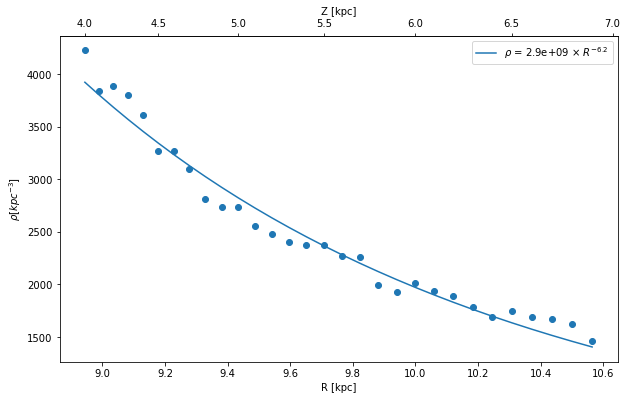

<Figure size 720x432 with 0 Axes>

In [36]:
extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.plot(dist_R, f1(dist_R, *param_f1), label='$\\rho$ = {:.2} $\\times$ $R^{{{:.2}}}$'.format(param_f1[0],-param_f1[1]))
secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')
plt.legend()
plt.figure()


In [37]:
sum(f1(np.linspace(90, 100, 10), *param_f1) * get_vol_elements(10, 1, 90, (1 * u.deg **2).to(u.sr).value))

0.0513646100096294

So there is about a 1/20 chance of finding a star between 90 kpc and 100 kpc

## A.2 Exclude high metallicity stars and force n=3

From class, we learned that the distances for high metallicity stars cannot be trusted after Z ~ 4, because they are likely misclassified low metallicity stars

<ipython-input-38-92af695d855b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)
<ipython-input-38-92af695d855b>:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])


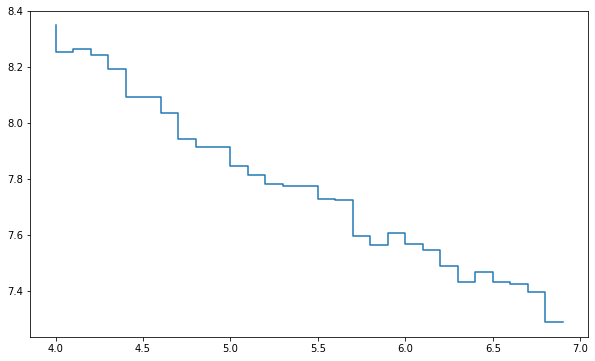

In [38]:
Z_min, Z_max = 4, 7
non_limited = gr24.loc[(gr24['Z(kpc)'] > Z_min) & (gr24['Z(kpc)'] < Z_max)]
# non_limited = gr24[gr24['Fe/H'] < -1]
non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)

nsteps = 30
step_size = (Z_max - Z_min)/nsteps
dist_Z, num, dens = plot_dens_hist(nsteps, step_size, Z_min, non_limited['Z(kpc)'], label='', return_vals=True)
dist_R = Z_to_R(dist_Z)

def f1(r, A):
    return A / r ** 3

halo_mask = [dist_Z > 5]

param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])

extr = np.linspace(9, 50, 92)

<Figure size 720x432 with 0 Axes>

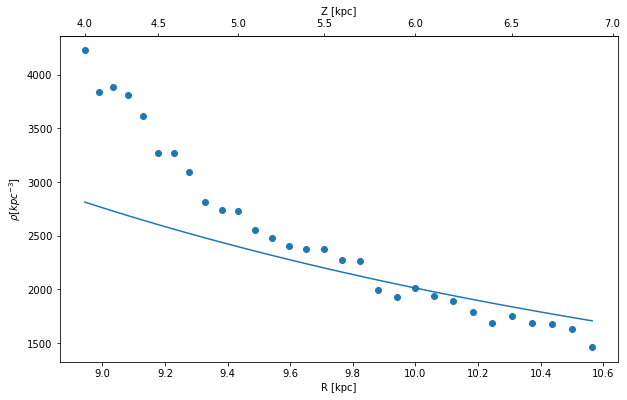

<Figure size 720x432 with 0 Axes>

In [39]:
ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.plot(dist_R, f1(dist_R, *param_f1))
secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()

In [40]:
integrated_total = sum(f1(np.linspace(90, 100, 100), *param_f1)  * get_vol_elements(100, .1, 90, (1 * u.deg **2).to(u.sr).value))
print(f"We expect to see around {int(integrated_total)} stars between 90 and 100 kpc")

We expect to see around 64 stars between 90 and 100 kpc


## A.3 Fitting with two distributions
Showing the two distribution nature of disk vs halo stars

In [41]:
Z_min, Z_max = 1, 7
non_limited = gr24.loc[(gr24['Z(kpc)'] > Z_min) & (gr24['Z(kpc)'] < Z_max)]
non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)

<ipython-input-41-6eedf4ecde31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)


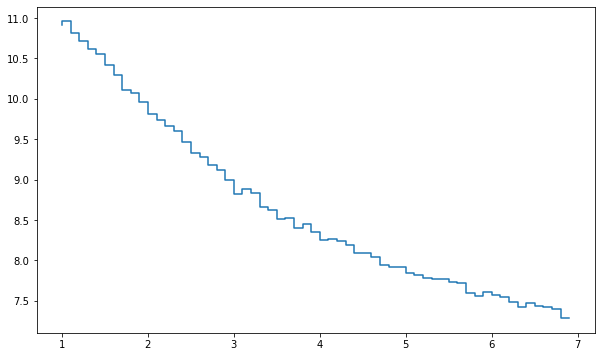

In [42]:
nsteps = 60
step_size = (Z_max - Z_min)/nsteps
dist_Z, num, dens = plot_dens_hist(nsteps, step_size, Z_min, non_limited['Z(kpc)'], label='', return_vals=True)
dist_R = Z_to_R(dist_Z)



In [43]:
def f1(r, A, n):
    return A / r ** n

def f2(r, A, b, r0):
    return A * np.exp(-b * (r - r0))

halo_mask = [dist_Z > 4]

param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])

disk_mask = [dist_Z < 3]
param_f2, _ = curve_fit(f2, dist_R[disk_mask], dens[disk_mask])

<ipython-input-43-3c9f414fdd12>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])
<ipython-input-43-3c9f414fdd12>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f2, _ = curve_fit(f2, dist_R[disk_mask], dens[disk_mask])


<Figure size 720x432 with 0 Axes>

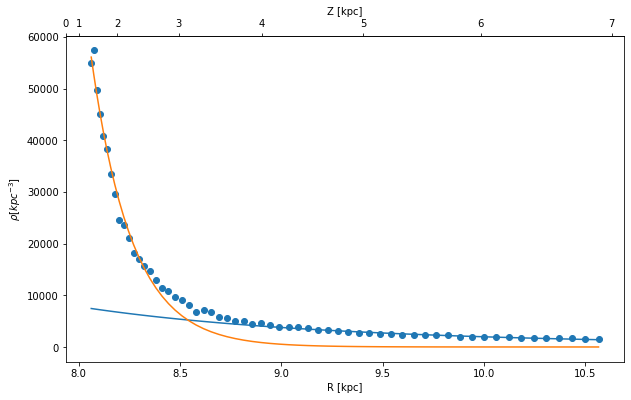

<Figure size 720x432 with 0 Axes>

In [44]:
extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.plot(dist_R, f1(dist_R, *param_f1))
ax.plot(dist_R, f2(dist_R, *param_f2))
# ax.plot(dist_R, f1(dist_R, *param_f1) + f2(dist_R, *param_f2))

secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()
# plt.plot(dist, f2(dist, *param_f2))

<ipython-input-45-46471079cd86>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.semilogy(dist_R[disk_mask], f2(dist_R[disk_mask], *param_f2))


<Figure size 720x432 with 0 Axes>

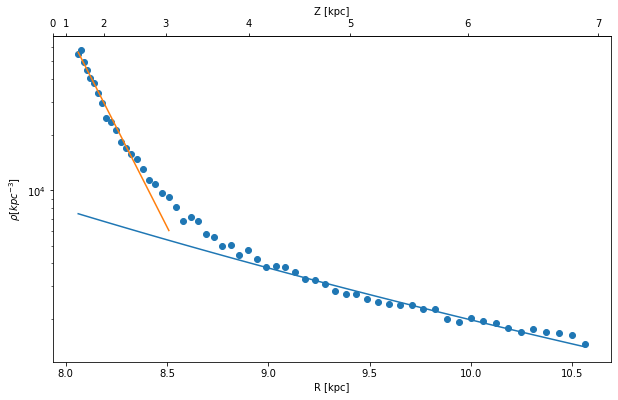

<Figure size 720x432 with 0 Axes>

In [45]:
extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.semilogy(dist_R, f1(dist_R, *param_f1))
ax.semilogy(dist_R[disk_mask], f2(dist_R[disk_mask], *param_f2))
# ax.plot(dist_R, f1(dist_R, *param_f1) + f2(dist_R, *param_f2))

secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()
# plt.plot(dist, f2(dist, *param_f2))

# Ignore after this point

#### Trying density function from the Ivezic 2008, with params from Juric 2008

In [292]:
Z_sun = 25  # pc
R_sun = 8000  #pc
H1 = 245  # pc
H2 = 743  # pc
e_D = .13
e_H = 0.0051
q_H = 0.64
n_H = 2.77
L1 = 2150
L2 = 3261
rho_D0 = 560440   # counts / kpc^3     

def rho_D(R):
    Z = np.sqrt(R ** 2 - 8000 ** 2)
    return rho_D0 * (np.exp(-np.abs(Z + Z_sun)/H1 - (R-R_sun)/L1) + e_D * np.exp(-np.abs(Z + Z_sun) / H2 - (R - R_sun) / L2)) 

def rho_H(R):
    Z = np.sqrt(R ** 2 - 8000 ** 2)
    return (rho_D0 * e_H * (R_sun ** 2 / (R ** 2 + (Z/q_H))) ** (n_H / 2))
    

<ipython-input-292-6e2f5cec86d5>:14: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(R ** 2 - 8000 ** 2)
<ipython-input-292-6e2f5cec86d5>:18: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(R ** 2 - 8000 ** 2)


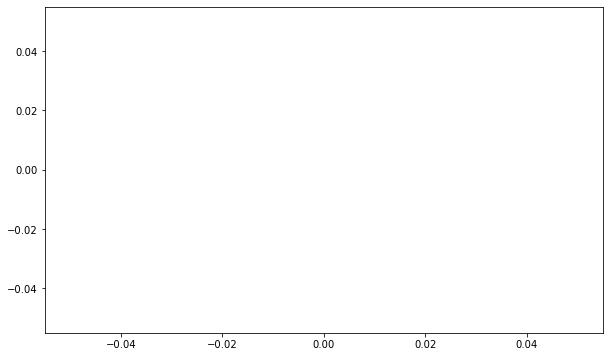

In [298]:
test = np.linspace(8.1, 15, 71)
plt.plot(test, (rho_D(test))/ (rho_D(test) + rho_H(test)))

<Figure size 720x432 with 0 Axes>

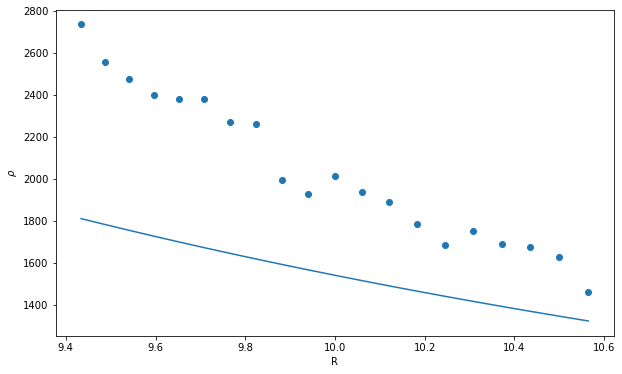

<Figure size 720x432 with 0 Axes>

In [295]:
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
import pdb


extr = np.linspace(9, 100, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
# ax.plot(dist_R, f1(dist_R, *param_f1))
# ax.plot(dist_R, f2(dist_R, *param_f2))
# ax.plot(dist_R, rho_D(dist_R*1000))
ax.plot(dist_R, rho_H(dist_R*1000))
ax.set_xlabel('R')
ax.set_ylabel(r'$\rho$')
plt.figure()

In [210]:
np.sqrt(4.5**2 + 64)

9.17877987534291

In [357]:
param_f1

array([2.89301049e+09, 6.16653150e+00])